In [ ]:
%load_ext autoreload
%autoreload 2
#from google.colab import drive
#drive.mount('/content/drive')
import sys
root = '/content/drive/My Drive/dialog-data/'
root = 'drive/dialog-data/'
sys.path.append(root)
!{sys.executable} -m pip install transformers
import time#
import sys
import os
import torch as T
import numpy as np
import transformers as tf
import slot_transfer_data as D
from collections import defaultdict
import argparse
import pickle

In [ ]:
class Run:
    def __init__(self):
        self.records = defaultdict(list)
        
    def log(self, key, value):
        self.records[key].append(value)


def evaluate(model, batch):
    token_type_ids = batch.x.token_type_ids
    if hasattr(model, 'roberta'):
        token_type_ids = T.zeros_like(batch.x.token_type_ids)
    scores = model(batch.x.input_ids, batch.x.attention_mask, batch.x.token_type_ids)[0]
    mask = batch.x.attention_mask[..., 0] # B.C
    scores = scores + (mask.float() - 1) * 1e8
    loss = T.nn.functional.cross_entropy(scores, batch.y)
    return scores, loss

def metrics(scores, labels):
    with T.no_grad():
        preds = T.max(scores, dim=-1)[1] == labels
        correct = T.where(preds == True)[0]
        wrong = T.where(preds == False)[0]
        return correct.shape[0]/scores.shape[0], correct.cpu().numpy(), wrong.cpu().numpy()
    
def print_example(tokenizer, batch, idx, scores, correct):
    with T.no_grad():
        ids, token_type_ids, mask = batch.x.input_ids[idx], batch.x.token_type_ids[idx], batch.x.attention_mask[idx, :, 0]
        scores = scores[idx]
        state = ('Correct' if correct else 'Wrong')
        print(' '.join(tokenizer.convert_ids_to_tokens(ids[0, token_type_ids[0] == 0], skip_special_tokens=True)))
        total = int(mask.sum())
        print('\t'.join([' '.join(tokenizer.convert_ids_to_tokens(ids[i, token_type_ids[i] == 1],
                                                                  skip_special_tokens=True))
                         + ': {:.2f}'.format(T.softmax(scores, dim=0)[i])
                         for i in range(total)] + [state]))

def train(model, optim, train_data, valid_data, no_batches, valid_duration=100,
          cuda=True, verbose=False, tokenizer=None, max_grad_norm=1.0,
          valid_size=1, run=None, batch_size=1, no_examples=10):
    if cuda:
        model = model.cuda()
    optim, scheduler = optim
    print("About to start training")
    start_time = time.time()
    valid_loss, valid_acc, max_acc = 0, 0, 0
    print_gpu = False
    batch_size, total_batch_size = batch_size
    no_iter = total_batch_size//batch_size
    i = 0
    while True:
        optim.zero_grad()
        scores, loss, acc = 0, 0, 0
        for k in range(no_iter):
            batch = next(train_data)
            scores_, loss_ = evaluate(model, batch)
            scores += scores_/no_iter
            loss_ /= no_iter
            loss_.backward()
            loss += loss_
            acc_, _, _ = metrics(scores_ , batch.y)
            acc += acc_/no_iter
        if max_grad_norm > 0:
            T.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        loss = float(loss)
        optim.step()
        scheduler.step()
        
        if  i % valid_duration == 0:
            model.eval()
            valid_acc, valid_loss = 0, 0
            with T.no_grad():
                if verbose:
                    print("##################################################################################")
                for k in range(valid_size):
                    batch = next(valid_data)
                    valid_scores, valid_los = evaluate(model, batch)
                    v_acc,  corr_ids, wrong_ids, = metrics(valid_scores, batch.y)
                    valid_loss += float(valid_los)
                    valid_acc += v_acc
                    if verbose and k < no_examples:
                        if len(corr_ids) > 0:
                            idx = np.random.choice(corr_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=True)
                            print("-----------------------------------------------------------------------------")
                        if len(wrong_ids) > 0:
                            idx = np.random.choice(wrong_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=False)
                            print("-----------------------------------------------------------------------------")
                if verbose:
                    print("##################################################################################")
                valid_loss /= valid_size
                valid_acc /= valid_size
                if valid_acc >= max_acc:
                    max_acc = valid_acc
                    model.save_model()        
            model.train()
        
        if print_gpu:
            print(nvgpu.gpu_info())
            print_gpu = False
        if run:
            run.log("train_loss", loss)
            run.log("train_acc", acc)
            run.log("valid_loss", valid_loss)
            run.log("valid_acc", valid_acc)
            run.log("batch", i)
        sys.stderr.write(f'\rtrain loss: {loss:.2f}\ttrain acc {acc:.2f}\t' + 
                         f'valid loss: {valid_loss:.2f}\tvalid acc {valid_acc:.2f}' +
                         f'\tbatch: {i}\ttime: {time.time()-start_time:.2f}{"": <30}')
        i += 1
        if i >= no_batches - 1:
            break
    return model

def _in(n, trainable_parameters):
    return any(nd in n for nd in trainable_parameters)

def get_model(name, trainable_parameters=None):
    model_name = name.split('-')[0].capitalize()
    tokenizer = getattr(tf, f'{model_name}Tokenizer').from_pretrained(name)
    model = getattr(tf, f'{model_name}ForMultipleChoice').from_pretrained(name)
    if trainable_parameters is not None:
        for name, param in model.named_parameters():
            if not _in(name, trainable_parameters):
                param.requires_grad = False
    return tokenizer, model


class AdapterLayer(T.nn.Module):
    
    def __init__(self, input_size, dropout, hidden_size=64, init_scale=1e-3, act='gelu'):
        super().__init__()
        self.act = getattr(T.nn.functional, act)
        self.squeeze = T.nn.Linear(input_size, hidden_size)
        self.squeeze.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.squeeze.bias.data)
        self.expand = T.nn.Linear(hidden_size, input_size)
        self.expand.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.expand.bias.data)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.dropout(x)
        return self.expand(self.act(self.squeeze(x))) + x
    

def add_adapter_layers(model, **kwargs):
    input_size = model.config.hidden_size
    layers = model.bert.encoder.layer
    for layer in layers:
        adapter1 = AdapterLayer(input_size, layer.attention.output.dropout, **kwargs)
        adapter2 = AdapterLayer(input_size, layer.output.dropout, **kwargs)
        layer.attention.output.add_module('dropout', adapter1)
        layer.output.add_module('dropout', adapter2)
    return model


def save_model(model, trainable_parameters, url):
    with open(url, 'wb') as f:
        params_to_save = {k: v.detach().cpu() for k, v in model.state_dict().items()
                          if _in(k, trainable_parameters)}
        pickle.dump(params_to_save, f)


def load_model(model, url):
    with open(url, 'rb') as f:
        return model.load_state_dict(pickle.load(f), False)


def main(args):
    
    data_dir = args.data_url
    trainable_parameters = (args.trainable_parameters.split(' ') if args.trainable_parameters != '' 
                                                                 else None)
    
    print("data directory is: " + data_dir)
    # Load the model
    tokenizer, model = get_model(args.model_name, trainable_parameters)
    # Load the data
    train_itr = D.SlotDataset(os.path.join(data_dir,'train'), tokenizer, # pos_prob=args.pos_prob,
                            max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                             shuffle=True, pin_memory=True,
                                                             cuda=True, loop=True, drop_last=True)
    valid_itr = D.SlotDataset(os.path.join(data_dir,'dev'), tokenizer, # pos_prob=1.0, 
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True, pin_memory=True,
                                                               cuda=True, loop=True, drop_last=True)
    # Train only adapter layers
    model = add_adapter_layers(model, hidden_size=args.adapter_size)
    if args.checkpoint:
        model.load_state_dict(pickle.load(open(os.path.join(data_dir, args.checkpoint), 'rb')), False)
    # Parallise if required
    if T.cuda.device_count() > 1:
        print("Let's use", T.cuda.device_count(), "GPUs!")
        model = T.nn.DataParallel(model)    
    # Create the optimizer
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and not _in(n, no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and _in(n, no_decay)],
            "weight_decay": 0.0
        },
    ]
    if args.model_url is not None:
        save_fn = lambda : save_model(model, trainable_parameters, 
                                      os.path.join(data_dir, args.model_url))
    else:
        save_fn = type(None)
    setattr(model, 'save_model', save_fn)
    optimizer = tf.AdamW(optimizer_grouped_parameters, lr=args.lr, eps=1e-8)
    scheduler = tf.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1*args.num_batches), num_training_steps=args.num_batches
    )
    
    optim = [optimizer, scheduler]
    run = Run()
    model = train(model, optim, train_itr, valid_itr, args.num_batches, args.valid_duration,
                  verbose=args.verbose, tokenizer=tokenizer, max_grad_norm=args.max_grad_norm,
                  valid_size=args.valid_size, run=run, cuda=True,
                  batch_size=[args.batch_size, args.total_batch_size])
    return model, run

In [ ]:
# get command-line arguments
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='bert-base-uncased')
parser.add_argument('--trainable_parameters', type=str, help='space separated parameters to train',
                    default=' '.join(trainable_parameters))
parser.add_argument('--total_batch_size', type=int, default=64, help='The total batch size')
parser.add_argument('--batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--num_batches', type=int, default=1000, help='number of batches to train')
parser.add_argument('--max_len', type=int, default=120, help='Maximum length of the context')
parser.add_argument('--adapter_size', type=int, default=256, help='hidden size of the adapter layers')
parser.add_argument('--data_url', type=str, help='data directory')
parser.add_argument('--pos_prob', type=float, default=0.5, help='Probability of sampling positive examples')
parser.add_argument('--optim', type=str, default='Adam', help='data directory')
parser.add_argument('--lr', type=float, default=6e-5, help='Learning rate')
parser.add_argument('--amsgrad', type=bool, default=False, help=' whether to use the AMSGrad variant')
parser.add_argument('--weight_decay', type=float, default=0.008, help='L2 Regularization weight decay')
parser.add_argument('--max_grad_norm', default=1.0, type=float, help="Max gradient norm.")
parser.add_argument('--valid_duration', type=int, default=100, help='The number of batches before validating')
parser.add_argument('--verbose', type=bool, default=True, help='Show Live valid examples with prediction during validating')
parser.add_argument('--valid_size', type=int, default=50, help='The number of valid batches to evaluate')
parser.add_argument('--model_url', type=str, default='model.pkl', help='URL to save the model')
parser.add_argument('--checkpoint', type=str, help='Start training from a checkpoint')

args = parser.parse_args(['--data_url', root, '--adapter_size', '512',# '--checkpoint', 'model_transfer_slot.pkl',
                          '--batch_size', '13', '--total_batch_size', '39', '--num_batches', '3000',
                            '--model_url', 'model_transfer_slot.pkl', 
                            ])
model, run = main(args)

data directory is: drive/dialog-data/
About to start training


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


##################################################################################
system : it ' s been booked and will cost you $ 190 in total user : great , now find me a hotel room to service description : a popular service for searching and res ##erving rooms in hotels to slot description : location of the hotel
from service description : car rental service with extensive coverage of locations and cars from slot description : location of rental car pickup: 0.50	from service description : car rental service with extensive coverage of locations and cars from slot description : city where rental car will be picked up: 0.50	Correct
-----------------------------------------------------------------------------
system : do you want to purchase a ticket user : not right now . can you find me a bus to get there to service description : book bus journeys from the biggest bus network in the country to slot description : city where bus is going to
from service description : the comprehensive p

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
train loss: 1.02	train acc 0.33	valid loss: 0.86	valid acc 0.46	batch: 99	time: 840.44                              

##################################################################################
system : the reservation fee is $ 56 . user : okay then . i need a bus that will travel there from washington on the 1st of march . i have 4 people in my party , total . to service description : book bus journeys from the biggest bus network in the country to slot description : city where bus is going to
from service description : car rental service with extensive coverage of locations and cars from slot description : location of rental car pickup: 0.50	from service description : car rental service with extensive coverage of locations and cars from slot description : city where rental car will be picked up: 0.50	Correct
-----------------------------------------------------------------------------
system : do you want to purchase a ticket user : not right now . can you find me a bus to get there to service description : book bus journeys from the biggest bus network in the country to slot description : ci

train loss: 0.10	train acc 0.95	valid loss: 0.86	valid acc 0.86	batch: 199	time: 1685.79                              

##################################################################################
system : do you want me to order tickets ? user : not just yet . can you check round trip flights ? i ' d like to go on the 3rd of this month . to service description : find one way and round trip flights to your favorite city to slot description : city in which the journey ends
from service description : book bus journeys from the biggest bus network in the country from slot description : city where bus is leaving from: 0.40	from service description : book bus journeys from the biggest bus network in the country from slot description : city where bus is going to: 0.60	Correct
-----------------------------------------------------------------------------
system : union station will be your station of origin . user : that sounds fine . what about any round ##trip flights that are going there ? to service description : find one way and round trip flights to your favorite city to slot description : city in w

train loss: 0.01	train acc 1.00	valid loss: 0.18	valid acc 0.93	batch: 299	time: 2531.53                              

##################################################################################
system : there ' s blue jays vs astros at rogers centre . that ' s popular . it ' s on march 13th at 6 : 30 pm . user : that ' s excellent . what are some hotels near there ? to service description : accommodation searching and booking portal to slot description : city or town where the accommodation is located
from service description : the comprehensive portal to find and reserve seats at events near you from slot description : city where event is happening: 1.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : name of event location: 0.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : street address of event location: 0.00	Correct
-----------------------------------------------------------------------------
system : the rental is $ 116 total . user : okay , 

train loss: 0.00	train acc 1.00	valid loss: 0.26	valid acc 0.94	batch: 399	time: 3377.40                              

##################################################################################
system : it ' s a blues event . user : sounds good . would you find me more hotels in that area ? to service description : accommodation searching and booking portal to slot description : city or town where the accommodation is located
from service description : the comprehensive portal to find and reserve seats at events near you from slot description : city where event is happening: 1.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : name of event location: 0.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : street address of event location: 0.00	Correct
-----------------------------------------------------------------------------
system : should i buy the ticket ? user : no thanks . can you get me a one - way flight there with delta airlines on the 10th of

train loss: 0.00	train acc 1.00	valid loss: 0.25	valid acc 0.93	batch: 499	time: 4220.44                              

##################################################################################
system : 123 - 01 roosevelt avenue at ci ##ti field . user : thanks . get a rental car to pick up 8th of march at 17 : 00 and return march 14th . to service description : car rental service with extensive coverage of locations and cars to slot description : city where rental car will be picked up
from service description : the comprehensive portal to find and reserve seats at events near you from slot description : city where event is happening: 1.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : name of event location: 0.00	from service description : the comprehensive portal to find and reserve seats at events near you from slot description : street address of event location: 0.00	Correct
-----------------------------------------------------------------------------
system : there is a 4 star hotel called hilton check ##ers los ang

train loss: 0.00	train acc 1.00	valid loss: 0.31	valid acc 0.92	batch: 599	time: 5063.81                              

##################################################################################
system : should we reserve a table now ? user : yes , let ' s go ahead and book for that day as well . to service description : a popular restaurant search and reservation service to slot description : tentative date of restaurant reservation
from service description : discover the right therapist for you and make reservations easily from slot description : date of the appointment: 1.00	from service description : discover the right therapist for you and make reservations easily from slot description : time of the appointment: 0.00	Correct
-----------------------------------------------------------------------------
system : do you want to purchase a ticket user : not right now . can you find me a bus to get there to service description : book bus journeys from the biggest bus network in the country to slot description : city where bus is going to
from service description : the comprehensive portal to fin

train loss: 0.00	train acc 1.00	valid loss: 0.28	valid acc 0.93	batch: 699	time: 5907.00                              

##################################################################################
system : your car has now been reserved . user : i need to find a hotel room there . i want it with wi ##fi and i need one room . to service description : a popular service for searching and res ##erving rooms in hotels to slot description : location of the hotel
from service description : car rental service with extensive coverage of locations and cars from slot description : location of rental car pickup: 0.00	from service description : car rental service with extensive coverage of locations and cars from slot description : city where rental car will be picked up: 1.00	Correct
-----------------------------------------------------------------------------
system : do you want to have tickets booked for this bus ? user : no , i am not interested in buying tickets for this bus now . can you find me a round trip flight to go there ? to service description : find one way and round trip flights to your favori

In [ ]:
!nvidia-smi

Thu May 14 21:55:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00002110:00:00.0 Off |                    0 |
| N/A   63C    P0    61W / 149W |      0MiB / 11441MiB |     88%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

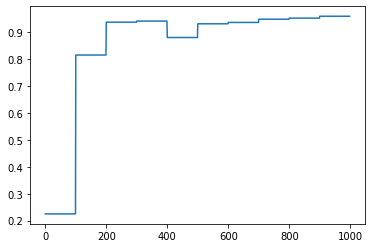

In [ ]:
plt.plot(run.records['valid_acc'])

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
save_model(model, trainable_parameters, root + 'model-transfer-slot-512-15-05.pkl')

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
tokenizer, model = get_model('bert-base-uncased', None)
model = add_adapter_layers(model, hidden_size=512)
load_model(model, root + 'model_transfer_slot.pkl')

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
valid_dataset = D.SlotDataset(os.path.join(root, 'dev'), tokenizer, max_len=120)
valid_data = valid_dataset.load_valid_data(batch_size=128)

In [ ]:
def evaluate_valid_data(model, valid_data):
    model.eval()
    with T.no_grad():
        acc, count = 0, 0
        scores, slots, ids = [], [], []
        for i, batch in enumerate(valid_data):
            batch = D.SlotDataset.map_to_cuda(batch)
            scores_, _ = evaluate(model, batch)
            acc_, _, _ = metrics(scores_, batch.y)
            acc += (acc_*len(batch.y))
            count += len(batch.y)
            scores.append(scores_.cpu().numpy())
            slots += batch.slot
            ids += batch.id
            sys.stderr.write(f'\r{i+1}/{len(valid_data)} acc: {acc_}{"": <30}')
        acc = acc/count
        scores = np.concatenate(scores)
    model.train()
    return {'acc': acc, 'scores': scores.tolist(), 'labels': slots, 'ids': ids}

In [ ]:
results = evaluate_valid_data(model.cuda(), valid_data)

7/7 acc: 1.0                              

In [ ]:
print(results['acc'])

0.8585858585858586


In [ ]:
print(results['acc'])

0.8652392947103275


In [ ]:
print(results['acc'])

0.8702770780856424


In [ ]:
print(results['acc'])

0.8838383838383839


In [ ]:
print(results['acc'])

0.8686868686868687


In [ ]:
print(results['acc'])

1.0


In [ ]:
print(results['acc'])

0.9994824016563147


In [ ]:
print(results['acc'])

1.0


In [ ]:
import json
with open(root + 'valid-transfer-value-scores.json', 'w') as f:
    json.dump(results, f)
#print(acc)